# Dichromatic MZI analysis

## Code written by Evan Klein w/ large contributions from Jesse Crawford

In [1]:
import numpy as np
import numpy.lib.recfunctions as rf
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

import warnings
warnings.filterwarnings('ignore')

# Importing binary files and binning data 

## Variable definitions; Change/check all values in this cell for each new data set

In [70]:
folder_path = 'D:/MZI/dichromatic/di_MZI_4/' # Location of folder data is held in
file_root = 'dichromatic_MZI_' # Start of each file name in folder (Everything up till the numbers)
nfiles = 129 # Total number of data files you have (careful as usually files start counting from 0 not 1)
exposure_time = 60 # Time in seconds of each exposure
motorMovementsPerExposure = 10 # Found in the motor moving code
bin_period = 0.50 # Time period you want each bin to span over in units of the time division you choose
time_div_label = "min" # Time scale you want to use for plotting choose from: ms, sec, min, hrs, days

In [71]:
# Dictionary defining time scale you want to use for plotting
time_div_dict = {"ms" : 1/60, "sec" : 1, "min" : 60, "hrs" : 3600, "days" : 3600*24}
time_div_val = time_div_dict[time_div_label]

In [72]:
total_time = nfiles * (exposure_time * 1/time_div_val)
nbins = np.round(total_time / bin_period).astype(int)
print(f"{nbins} bins will be created over {total_time} {time_div_label}, meaning each bin has a period of {nfiles/nbins} {time_div_label}")

258 bins will be created over 129.0 min, meaning each bin has a period of 0.5 min


# Functions to find theoretical interference frequency

In [73]:
# https://en.wikipedia.org/wiki/Sellmeier_equation
def sellemeier_bk7(wavelength): # Measured in nm
    return np.sqrt(1 + 1.03961212*wavelength**2/(wavelength**2-6.00069867e3) + 0.231792344*wavelength**2/(wavelength**2-2.00179144e4) + 1.01046945*wavelength**2/(wavelength**2-1.03560653e8))

In [74]:
# Only works if motor code is still giving a steps command of value 32 
# (32 steps corresponds to a motor movement of 2.5 microns, scale the 2.5 in the fxn below to the correct value if needed)
# Returns in inverse units of time divisions being used for display units
def find_int_freq(wavelength, motorMovementsPerExposure=motorMovementsPerExposure, exposure_time=exposure_time, time_div_val=time_div_val):
    return(1000*2.5*motorMovementsPerExposure*np.tan(np.radians(1))*(sellemeier_bk7(wavelength)-1) / (wavelength*exposure_time)) * time_div_val

### Creating global bins from start timestamp to end timestamp

In [14]:
start_file = folder_path + file_root + str(0+1) + '.bin'
end_file = folder_path + file_root + str(nfiles) + '.bin'

# Creating bin edges to use in data aggregation
start_time = rf.structured_to_unstructured(np.fromfile(start_file, dtype = [('t','q'),('c','h')], offset=40))[1:][0][0]

end_time = rf.structured_to_unstructured(np.fromfile(end_file, dtype = [('t','q'),('c','h')], offset=40))[1:][-1][0]

print("Start time:", start_time)
print("End time:", end_time)

hist_bins = np.linspace(start_time, end_time, nbins+1) # nbins+1 is to ensure this is bin edges not just centers
hist_bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2.0 # List of centers of bins (Shorter than bin edges list by 1)

Start time: 13326837059700488
End time: 21030311741584419


## Iterating through files

In [15]:
hist_vals_1 = np.zeros(nbins)
hist_vals_2 = np.zeros(nbins)

for i in tqdm(range(nfiles)): # tqdm shows a progress bar
    file = folder_path + file_root + str(i+1) + '.bin' # Each file is its own exposure
    data_arr = rf.structured_to_unstructured(np.fromfile(file, dtype = [('t','q'),('c','h')], offset=40)) # Doing magic to get data from binary file
    data_arr = data_arr[1:] # Trimming first entry in each file as it says its from senor #104???
    
    # Seperating timestamps from single file into two lists
    timestamps_1 = data_arr[np.where(data_arr[:,1]==1)][:,0]
    timestamps_2 = data_arr[np.where(data_arr[:,1]==2)][:,0]
    
    # Aggregating timestamps into global histogram bins
    hist_vals_1 += np.histogram(timestamps_1, bins=hist_bins)[0]
    hist_vals_2 += np.histogram(timestamps_2, bins=hist_bins)[0]

100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [14:32<00:00,  6.76s/it]


### Changing timestamps into real units

In [16]:
# Converting bin values from arbitrary timestamps to real time from start of experiment
bin_centers_rt = (np.array(hist_bin_centers) - start_time)/1e12/time_div_val

In [17]:
print(f"The first 10 elements of the bin_centers list are: \n{bin_centers_rt[:10]}\n")
print(f"There are {bin_centers_rt.size} bins total")

The first 10 elements of the bin_centers list are: 
[0.24690624 0.74071872 1.2345312  1.72834368 2.22215616 2.71596864
 3.20978112 3.7035936  4.19740608 4.69121856]

There are 260 bins total


# Preliminary plot of data

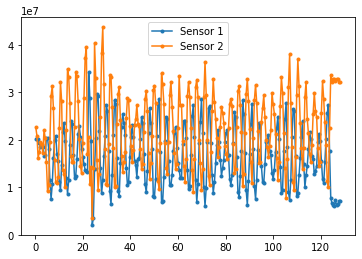

In [18]:
plt.plot(bin_centers_rt, hist_vals_1, marker='.', label='Sensor 1')
plt.plot(bin_centers_rt, hist_vals_2, marker='.', label='Sensor 2')

plt.ylim(bottom=0)

plt.legend()
plt.show()

### Zooming in and normalizing

In [40]:
# Times you want the modeling to start and end at (measured in minutes, seconds, etc.)
model_start = 5
model_end = 120

In [41]:
# Finding closest index in bin_centers_rt array to above values
start_index = np.argmin(np.abs(bin_centers_rt-model_start))
end_index = np.argmin(np.abs(bin_centers_rt-model_end))

print(start_index, end_index)

10 243


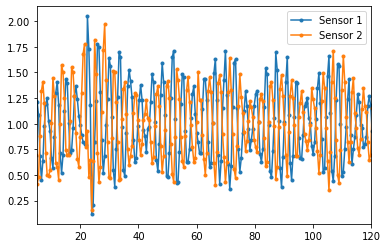

In [42]:
plt.plot(bin_centers_rt, hist_vals_1 / np.average(hist_vals_1), marker='.', label='Sensor 1')
plt.plot(bin_centers_rt, hist_vals_2 / np.average(hist_vals_2), marker='.', label='Sensor 2')

plt.xlim(model_start, model_end)

plt.legend()
plt.show()

### Sum of normalization (ideally should be constant)

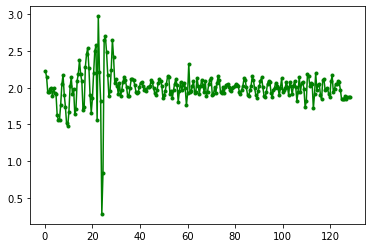

In [43]:
plt.plot(bin_centers_rt, hist_vals_1 / np.average(hist_vals_1) + hist_vals_2 / np.average(hist_vals_2), marker='.', color='Green')
#plt.xlim(model_start, model_end)

plt.show()

### Difference of sensors over their sum

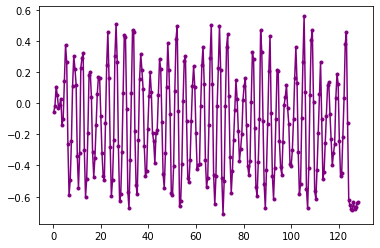

In [44]:
diff_over_sum = (hist_vals_1 - hist_vals_2) / (hist_vals_1 + hist_vals_2)
diff_over_sum[np.isnan(diff_over_sum)] = 0 # Replacing possible divide by 0 nan values with 0

plt.plot(bin_centers_rt, diff_over_sum, marker='.', color='Purple')
#plt.xlim(20, 60)

plt.show()

# Fourier analysis

In [45]:
signal_1 = hist_vals_1[start_index:end_index]
signal_2 = hist_vals_2[start_index:end_index]

fft_1 = np.fft.fft(signal_1)
fft_2 = np.fft.fft(signal_2)
fft_vis = np.fft.fft(diff_over_sum[start_index:end_index])

frequencies = np.fft.fftfreq(len(signal_1), bin_centers_rt[1] - bin_centers_rt[0])

### Finding highest peaks in frequency space (Change frequency_distance as needed for proper peaks separation)

In [46]:
frequency_distance = 0.05

In [47]:
def find_second_peak(frequencies, fft_modulus_list, args_sorted_list, first_freq, frequency_distance):
    args_sorted_list_clipped = args_sorted_list[2:] # Values 0 & 1 are 0 Hz and first peak respectively
    for i, frequency_index in enumerate(args_sorted_list_clipped):
        #print(frequencies[frequency_index], np.abs(frequencies[frequency_index] - first_freq))
        if np.abs(frequencies[frequency_index] - first_freq) > frequency_distance:
            return frequencies[frequency_index], frequency_index

In [48]:
# len(fft_1)//2 is position of the Nyquist frequency, values after that are negative reflections
fft_modulus_1 = np.abs(fft_1[:len(fft_1)//2]) 
fft_modulus_2 = np.abs(fft_2[:len(fft_2)//2])

args_sorted_1 = np.argsort(fft_modulus_1)[::-1] # [::-1] makes things ordered greatest to least
args_sorted_2 = np.argsort(fft_modulus_2)[::-1]

# args_sorted[0] usually corresponds to constant offset value at 0 Hz
first_freq = np.average([frequencies[args_sorted_1[1]], frequencies[args_sorted_2[1]]])

# Need to find next highest peak some distance away from the first
second_freq_1, second_freq_index_1 = find_second_peak(frequencies, fft_modulus_1, args_sorted_1, first_freq, frequency_distance)
second_freq_2, second_freq_index_2 = find_second_peak(frequencies, fft_modulus_2, args_sorted_2, first_freq, frequency_distance)

second_freq = np.average([second_freq_1, second_freq_2])

print(f"Highest frequency on sensor 1: {frequencies[args_sorted_1[1]]} {time_div_label}⁻¹")
print(f"Highest frequency on sensor 2: {frequencies[args_sorted_2[1]]} {time_div_label}⁻¹")
print(f"Second highest frequency on sensor 1: {second_freq_1} {time_div_label}⁻¹")
print(f"Second highest frequency on sensor 2: {second_freq_2} {time_div_label}⁻¹\n")

print(f"Highest frequency average: {first_freq} {time_div_label}⁻¹")
print(f"Second highest frequency average: {second_freq} {time_div_label}⁻¹")

Highest frequency on sensor 1: 0.27811985615070656 min⁻¹
Highest frequency on sensor 2: 0.27811985615070656 min⁻¹
Second highest frequency on sensor 1: 0.33026732917896406 min⁻¹
Second highest frequency on sensor 2: 0.33026732917896406 min⁻¹

Highest frequency average: 0.27811985615070656 min⁻¹
Second highest frequency average: 0.33026732917896406 min⁻¹


### Defining limits on this and all subsequent frequency plots

In [58]:
freq_plot_xlims = [0, 0.5]
freq_plot_ylims = [0, 2e9]

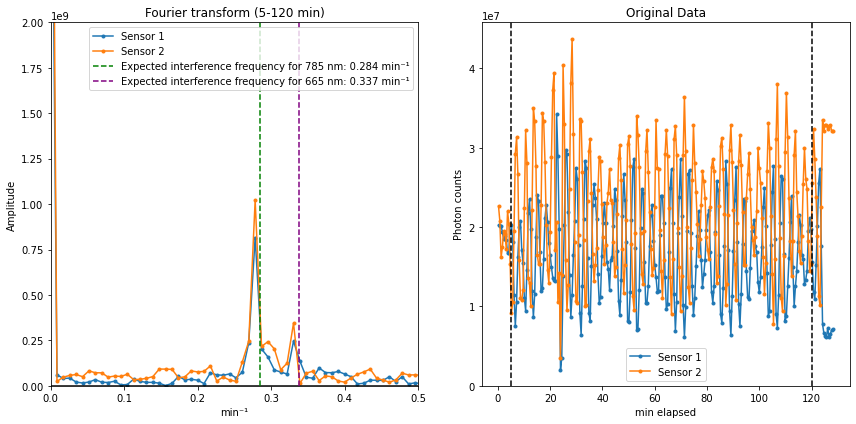

In [75]:
fft_fig = plt.figure(figsize = (12, 6))

# Frequency domain
plt.subplot(121)
plt.plot(frequencies[:len(fft_1)//2], fft_modulus_1, marker='.', label='Sensor 1')
plt.plot(frequencies[:len(fft_1)//2], fft_modulus_2, marker='.', label='Sensor 2')

plt.axhline(y=0, color='Black')
plt.axvline(x=find_int_freq(785), color='Green', ls='--',
            label=f'Expected interference frequency for 785 nm: {find_int_freq(785):.3f} {time_div_label}⁻¹')
plt.axvline(x=find_int_freq(665), color='Purple', ls='--',
            label=f'Expected interference frequency for 665 nm: {find_int_freq(665):.3f} {time_div_label}⁻¹')

plt.xlim(freq_plot_xlims)
plt.ylim(freq_plot_ylims)

plt.xlabel(f"{time_div_label}⁻¹")
plt.ylabel("Amplitude")
plt.title(f"Fourier transform ({model_start}-{model_end} {time_div_label})")
plt.legend()

# Time domain from before being modeled
plt.subplot(122)
plt.plot(bin_centers_rt, hist_vals_1, marker='.', label='Sensor 1')
plt.plot(bin_centers_rt, hist_vals_2, marker='.', label='Sensor 2')

plt.axvline(x=model_start, color='Black', ls='--')
plt.axvline(x=model_end, color='Black', ls='--')

plt.ylim(bottom=0)

plt.title("Original Data")
plt.xlabel(f"{time_div_label} elapsed")
plt.ylabel("Photon counts")
plt.legend()

fft_fig.tight_layout()
plt.show()

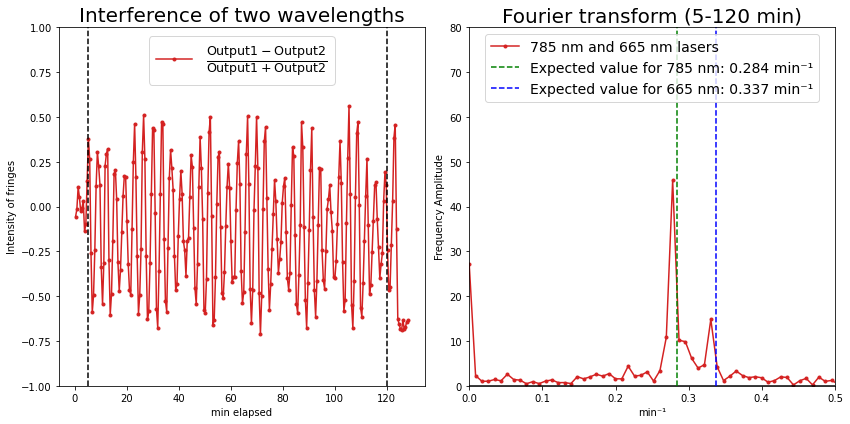

In [119]:
fft_fig = plt.figure(figsize = (12, 6))

# Frequency domain
plt.subplot(122)
plt.plot(frequencies[:len(fft_vis)//2], np.abs(fft_vis[:len(fft_vis)//2]), marker='.',
         color='#d42222', label='785 nm and 665 nm lasers')

plt.axhline(y=0, color='Black')
plt.axvline(x=find_int_freq(785), color='g', ls='--',
            label=f'Expected value for 785 nm: {find_int_freq(785):.3f} {time_div_label}⁻¹')
plt.axvline(x=find_int_freq(665), color='b', ls='--',
            label=f'Expected value for 665 nm: {find_int_freq(665):.3f} {time_div_label}⁻¹')

plt.xlim(freq_plot_xlims)
plt.ylim(0, 80)

plt.xlabel(f"{time_div_label}⁻¹")
plt.ylabel("Frequency Amplitude")
plt.title(f"Fourier transform ({model_start}-{model_end} {time_div_label})", fontsize=20)
plt.legend(fontsize=14, loc=9)

# Time domain from before being modeled
plt.subplot(121)
plt.plot(bin_centers_rt, diff_over_sum, marker='.', color='#d42222', 
         label=r"$\mathrm{\frac{Output 1 - Output 2}{Output 1 + Output 2}}$")

plt.axvline(x=model_start, color='Black', ls='--')
plt.axvline(x=model_end, color='Black', ls='--')

plt.ylim(-1, 1)

plt.title("Interference of two wavelengths", fontsize=20)
plt.xlabel(f"{time_div_label} elapsed")
plt.ylabel("Intensity of fringes")
plt.legend(fontsize=18, loc=9)

fft_fig.tight_layout()
plt.show()

## Filtering frequencies out

In [52]:
max_freq = 0.5 # Frequencies above this value will be removed from the frequency space data

# Setting all values above max freq to 0
fft_filt_1 = fft_1.copy()
fft_filt_1[np.abs(frequencies) > max_freq] = 0
fft_filt_2 = fft_2.copy()
fft_filt_2[np.abs(frequencies) > max_freq] = 0

# Turning filtered fft's into real time domain again
filtered_1 = np.fft.ifft(fft_filt_1)
filtered_2 = np.fft.ifft(fft_filt_2)

In [53]:
residual_filtered_1 = hist_vals_1[start_index:end_index] - filtered_1
residual_filtered_2 = hist_vals_2[start_index:end_index] - filtered_2

# Chi^2
chi_filtered_1 = np.sum(residual_filtered_1**2 / filtered_1)
chi_filtered_2 = np.sum(residual_filtered_2**2 / filtered_2)

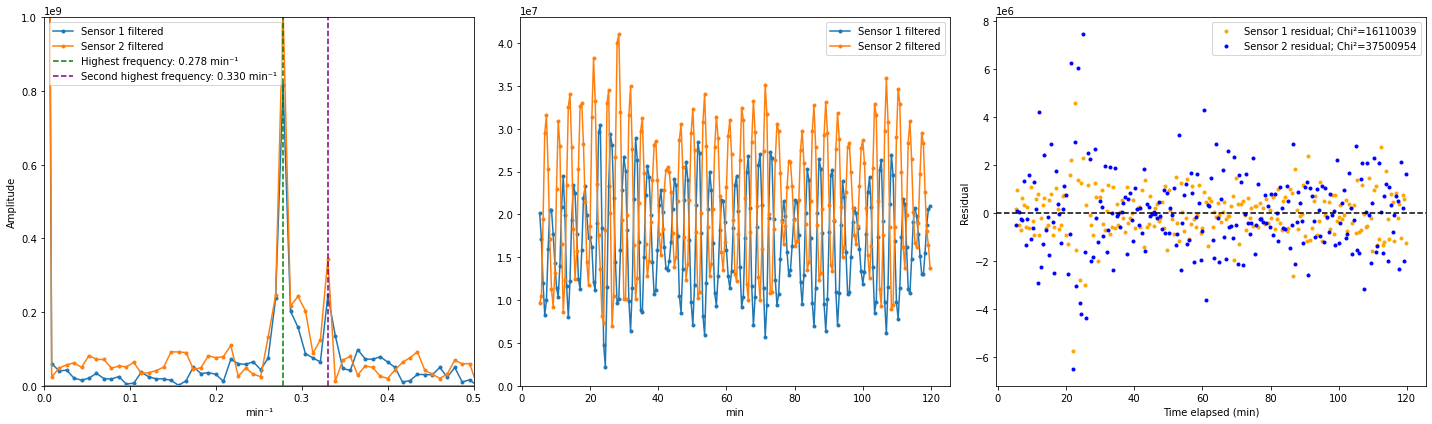

In [54]:
# Plotting filtered signal in time and frequency domains w/ residual
fft_filtered_fig = plt.figure(figsize = (20, 6))

# Frequency domain
plt.subplot(131)
plt.plot(frequencies, np.abs(fft_filt_1), marker='.', label='Sensor 1 filtered')
plt.plot(frequencies, np.abs(fft_filt_2), marker='.', label='Sensor 2 filtered')

plt.axvline(x=first_freq, color='Green', ls='--',
            label=f'Highest frequency: {first_freq:.3f} {time_div_label}⁻¹')
plt.axvline(x=second_freq, color='Purple', ls='--',
            label=f'Second highest frequency: {second_freq:.3f} {time_div_label}⁻¹')

plt.xlim(freq_plot_xlims)
plt.ylim(freq_plot_ylims)

plt.legend()
plt.xlabel(f"{time_div_label}⁻¹")
plt.ylabel("Amplitude")

# Time domain
plt.subplot(132)
plt.plot(bin_centers_rt[start_index:end_index], filtered_1, marker='.', label='Sensor 1 filtered')
plt.plot(bin_centers_rt[start_index:end_index], filtered_2, marker='.', label='Sensor 2 filtered')

plt.ylim(bottom=0)

plt.legend()
plt.xlabel(f"{time_div_label}")

# Residual in time domain (Residual = Observed - Predicted)
plt.subplot(133)

plt.plot(bin_centers_rt[start_index:end_index], residual_filtered_1, 
         label=f"Sensor 1 residual; Chi²={np.round(chi_filtered_1).astype(int)}", color='Orange', marker='.', ls='None')
plt.plot(bin_centers_rt[start_index:end_index], residual_filtered_2, 
         label=f"Sensor 2 residual; Chi²={np.round(chi_filtered_2).astype(int)}", color='Blue', marker='.', ls='None')
plt.axhline(y=0, color='black', linestyle='--')

#plt.xlim(0, 1)

plt.legend()

#plt.title(f"Residual plot")
plt.xlabel(f"Time elapsed ({time_div_label})")
plt.ylabel("Residual")

fft_filtered_fig.tight_layout()
plt.show()

In [55]:
# Setting all frequencies besides two found before and the one at 0 Hz to 0
fft_ideal_1 = [0]*len(fft_1) # Creating list of 0s same length as fft list
fft_ideal_1[0] = fft_1[0] # Constant offset value at 0 Hz for this sensor
fft_ideal_1[args_sorted_1[1]] = fft_1[args_sorted_1[1]] # First frequency peak for this sensor
fft_ideal_1[second_freq_index_1] = fft_1[second_freq_index_1] # Second frequency peak for this sensor
fft_ideal_1[-args_sorted_1[1]] = fft_1[-args_sorted_1[1]] # Also recovering negative frequencies at same places
fft_ideal_1[-second_freq_index_1] = fft_1[-second_freq_index_1]

# Same for sensor 2
fft_ideal_2 = [0]*len(fft_2)
fft_ideal_2[0] = fft_2[0]
fft_ideal_2[args_sorted_2[1]] = fft_2[args_sorted_2[1]]
fft_ideal_2[second_freq_index_2] = fft_2[second_freq_index_2]
fft_ideal_2[-args_sorted_2[1]] = fft_2[-args_sorted_2[1]]
fft_ideal_2[-second_freq_index_2] = fft_2[-second_freq_index_2]

# Turning ideal fft's into real time domain again
ideal_1 = np.fft.ifft(fft_ideal_1)
ideal_2 = np.fft.ifft(fft_ideal_2)

In [56]:
residual_ideal_1 = hist_vals_1[start_index:end_index] - ideal_1
residual_ideal_2 = hist_vals_2[start_index:end_index] - ideal_2

# Chi^2
chi_ideal_1 = np.sum(residual_ideal_1**2 / ideal_1)
chi_ideal_2 = np.sum(residual_ideal_2**2 / ideal_2)

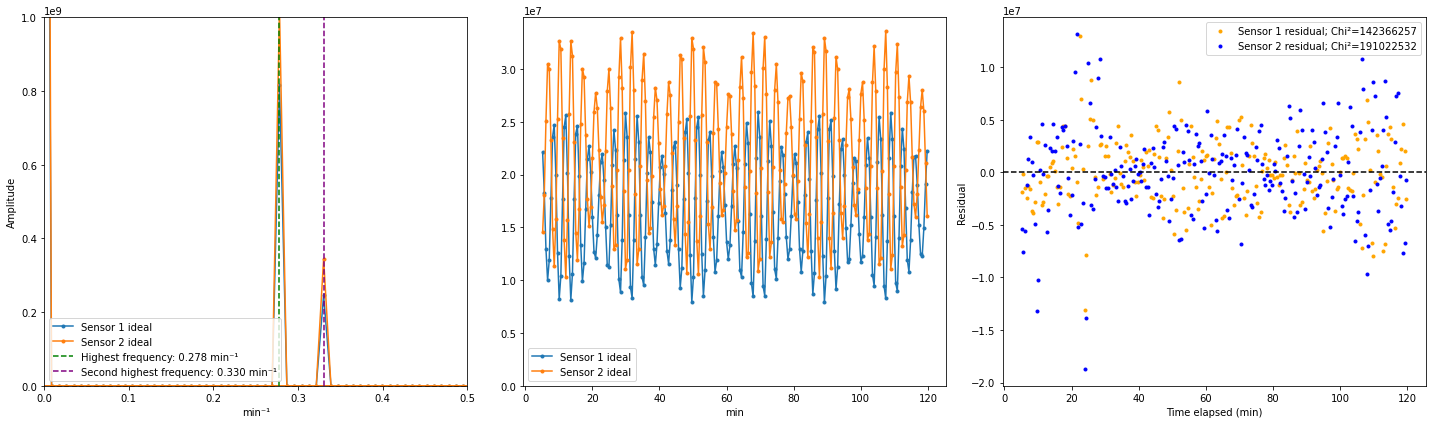

In [57]:
# Plotting ideal signal in time and frequency domains
fft_ideal_fig = plt.figure(figsize = (20, 6))

# Frequency domain
plt.subplot(131)
plt.plot(frequencies, np.abs(fft_ideal_1), marker='.', label='Sensor 1 ideal')
plt.plot(frequencies, np.abs(fft_ideal_2), marker='.', label='Sensor 2 ideal')

plt.axvline(x=first_freq, color='Green', ls='--',
            label=f'Highest frequency: {first_freq:.3f} {time_div_label}⁻¹')
plt.axvline(x=second_freq, color='Purple', ls='--',
            label=f'Second highest frequency: {second_freq:.3f} {time_div_label}⁻¹')

plt.xlim(freq_plot_xlims)
plt.ylim(freq_plot_ylims)

plt.legend()
plt.xlabel(f"{time_div_label}⁻¹")
plt.ylabel("Amplitude")

# Time domain
plt.subplot(132)
plt.plot(bin_centers_rt[start_index:end_index], ideal_1, marker='.', label='Sensor 1 ideal')
plt.plot(bin_centers_rt[start_index:end_index], ideal_2, marker='.', label='Sensor 2 ideal')

plt.ylim(bottom=0)

plt.legend()
plt.xlabel(f"{time_div_label}")

# Residual in time domain (Residual = Observed - Predicted)
plt.subplot(133)
plt.plot(bin_centers_rt[start_index:end_index], residual_ideal_1, 
         label=f"Sensor 1 residual; Chi²={np.round(chi_ideal_1).astype(int)}", color='Orange', marker='.', ls='None')
plt.plot(bin_centers_rt[start_index:end_index], residual_ideal_2, 
         label=f"Sensor 2 residual; Chi²={np.round(chi_ideal_2).astype(int)}", color='Blue', marker='.', ls='None')
plt.axhline(y=0, color='black', linestyle='--')

#plt.xlim(0, 1)

plt.legend()

#plt.title(f"Residual plot")
plt.xlabel(f"Time elapsed ({time_div_label})")
plt.ylabel("Residual")

fft_ideal_fig.tight_layout()
plt.show()